## Import packages

In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import scipy as scipy
#import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [3]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

time_slice = slice('1980-01-01', '2021-12-31')

lat_circumf = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a
m_per_lat = 111000

### Load instantaneous AHT calcs

In [4]:
aht_ds_6hrly = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc').sel(time=time_slice)
aht_ds_6hrly

<xarray.Dataset>
Dimensions:                     (time: 61364, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1980-01-01 ... 2021-12-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

### Get JJA and DJF 6-hrly data

In [5]:
aht_6hrly_jja = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([6, 7, 8]))
aht_6hrly_djf = aht_ds_6hrly.sel(time=aht_ds_6hrly.time.dt.month.isin([1, 2, 12]))

In [6]:
aht_grad_djf = aht_6hrly_djf.differentiate('latitude')
aht_grad_jja = aht_6hrly_jja.differentiate('latitude')

In [7]:
latent_heat_ds = xr.open_mfdataset('../era5_raw_data/surface_fluxes/surface_latent_heat_flux_*.nc')
sensible_heat_ds = xr.open_mfdataset('../era5_raw_data/surface_fluxes/surface_sensible_heat_flux_*.nc')
surface_lw_ds = xr.open_mfdataset('../era5_raw_data/radiation/surface_net_thermal_radiation_*.nc')
surface_sw_ds = xr.open_mfdataset('../era5_raw_data/radiation/surface_net_solar_radiation_*.nc')
toa_sw_ds = xr.open_mfdataset('../era5_raw_data/radiation/top_net_solar_radiation_*.nc')
toa_lw_ds = xr.open_mfdataset('../era5_raw_data/radiation/top_net_thermal_radiation_*.nc')


In [8]:
lh = latent_heat_ds.slhf.mean('longitude') / 3600
sh = sensible_heat_ds.sshf.mean('longitude') / 3600
sf_lw = surface_lw_ds.str.mean('longitude') / 3600
sf_sw = surface_sw_ds.ssr.mean('longitude') / 3600
toa_lw = toa_lw_ds.ttr.mean('longitude') / 3600
toa_sw = toa_sw_ds.tsr.mean('longitude') / 3600

surface_fluxes = -(lh + sh).compute()
surface_fluxes_djf = surface_fluxes.sel(time=surface_fluxes.time.dt.month.isin([12, 1, 2]))
surface_fluxes_jja = surface_fluxes.sel(time=surface_fluxes.time.dt.month.isin([6, 7, 8]))

radiation = (toa_lw + toa_sw - sf_sw - sf_lw).compute()
radiation_djf = radiation.sel(time=radiation.time.dt.month.isin([12, 1, 2]))
radiation_jja = radiation.sel(time=radiation.time.dt.month.isin([6, 7, 8]))

In [ ]:
lh.mean('time').plot(label='LH')
sh.mean('time').plot(label='SH')
sf_lw.mean('time').plot(label='SF LW')
sf_sw.mean('time').plot(label='SF SW')
toa_lw.mean('time').plot(label='TOA LW')
toa_sw.mean('time').plot(label='TOA SW')

plt.legend(loc=0)

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7df7d12af0> (for post_execute):


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/IPython/core/events.py", line 89, in trigger
    func(*args, **kwargs)
  File "/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/matplotlib/pyplot.py", line 138, in post_execute
    draw_all()
  File "/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/matplotlib/_pylab_helpers.py", line 138, in draw_all
    manager.canvas.draw_idle()
  File "/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 2012, in draw_idle
    self.draw(*args, **kwargs)
  File "/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "/tdat/tylersc/mini3/envs/jupyter_new/lib/python3.9/site-packages/matplotlib/artist.py", line 41, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "/tdat/tylersc/mini3/envs/

In [13]:
lh_djf = lh.sel(time=lh.time.dt.month.isin([12, 1, 2]))
lh_jja = lh.sel(time=lh.time.dt.month.isin([6, 7, 8]))

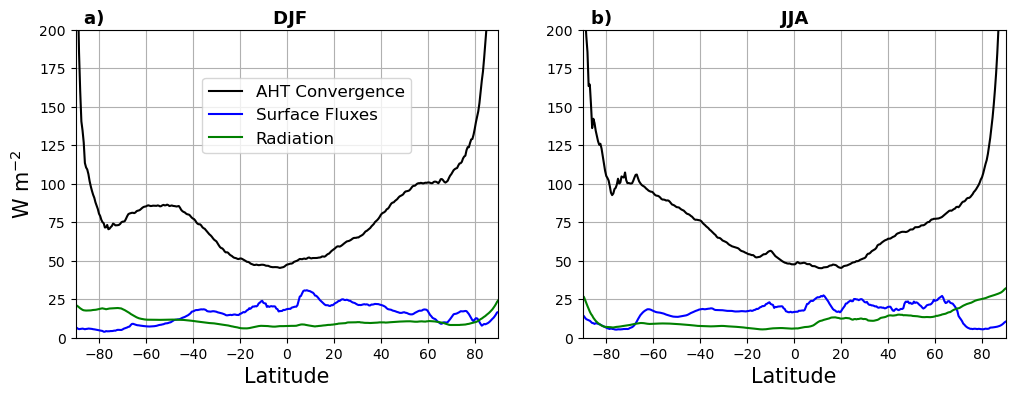

In [15]:
fig, axs = plt.subplots(ncols=2, nrows = 1, figsize=(12, 4))

axs[0].plot(lats, (aht_grad_djf.total_aht / lat_circumf / m_per_lat).std('time'), color='k',
           label='AHT Convergence')
#axs[0].plot(lats, (aht_grad_djf.eddy_aht / lat_circumf / m_per_lat).std('time'), color='b')
#axs[0].plot(lats, (aht_grad_djf.mmc_aht / lat_circumf / m_per_lat).std('time'), color='#E69F00')
axs[0].plot(lats, surface_fluxes_djf.std('time'), color='b',
           label='Surface Fluxes')
axs[0].plot(lats, radiation_djf.std('time'), color='g',
           label='Radiation')

axs[0].legend(loc=(0.3, 0.6), fontsize=12)

axs[1].plot(lats, (aht_grad_jja.total_aht / lat_circumf / m_per_lat).std('time'), color='k')
#axs[1].plot(lats, (aht_grad_jja.eddy_aht / lat_circumf / m_per_lat).std('time'), color='b')
#axs[1].plot(lats, (aht_grad_jja.mmc_aht / lat_circumf / m_per_lat).std('time'), color='#E69F00')
axs[1].plot(lats, surface_fluxes_jja.std('time'), color='b')
axs[1].plot(lats, radiation_jja.std('time'), color='g')

axs[0].grid()
axs[1].grid()
axs[0].set_ylim([0,200])
axs[1].set_ylim([0,200])
axs[0].set_xlim([-90, 90])
axs[1].set_xlim([-90, 90])
axs[0].set_ylabel('W m$^{-2}$', fontsize=15)
axs[0].set_xlabel('Latitude', fontsize=15)
axs[1].set_xlabel('Latitude', fontsize=15)

axs[0].text(x=0.02, y=1.02, s='a)                           DJF',
            transform=axs[0].transAxes, fontsize=13, fontweight='bold')
axs[1].text(x=0.02, y=1.02, s='b)                           JJA',
            transform=axs[1].transAxes, fontsize=13, fontweight='bold')

#plt.savefig('figures/aht_convergence_rad_surf_fluxes_comp')
plt.show()